# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

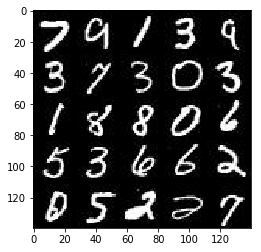

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

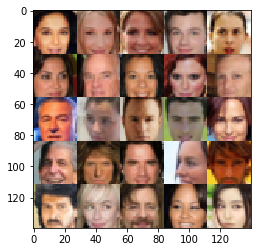

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [159]:
def leakyrelu(net, alpha = 0.1, name = 'leaky_relu'):    
    return tf.maximum(alpha * net, net, name=name)


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    is_training = True
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 32, 9, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = leakyrelu(conv1)

        conv2 = tf.layers.conv2d(conv1, 64, 9, strides=1, padding='SAME')
        conv2 = tf.layers.dropout(conv2, rate=0.8, training=is_training)
        conv2 = leakyrelu(conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 9, strides=2, padding='SAME')
        conv3 = tf.layers.dropout(conv3, rate=0.8, training=is_training)
        conv3 = leakyrelu(conv3)

        flattened = tf.reshape(conv3, (-1, 7 * 7 * 128))
        logits = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [160]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function    
    with tf.variable_scope('generator', reuse=not is_train):
        inputs = tf.layers.dense(z, 7 * 7 * 512)
        
        conv1 = tf.reshape(inputs, (-1, 7, 7, 512))        
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = leakyrelu(conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 64, 9, strides=2, padding='SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = leakyrelu(conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, 32, 9, strides=1, padding='SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = leakyrelu(conv3)
        
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 9, strides=2, padding='SAME')
        
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [161]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.random_uniform(tf.shape(d_model_real),0.7,1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.random_uniform(tf.shape(d_model_fake),0.0,0.3)))
    g_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.random_uniform(tf.shape(d_model_fake),0.7,1.2)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [162]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):    
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [163]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [164]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            steps = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_real_scaled = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_real_scaled, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate, input_real: batch_real_scaled})
                
                if steps % 10 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_real_scaled})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch: {}/{}({})...'.format(epoch_i+1, epochs, steps),
                         'Discriminator Loss: {:4f}...'.format(d_train_loss),
                         'Generator Loss: {:4f}'.format(g_train_loss))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)                   
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2(10)... Discriminator Loss: 1.260879... Generator Loss: 0.592715
Epoch: 1/2(20)... Discriminator Loss: 1.354968... Generator Loss: 0.486417
Epoch: 1/2(30)... Discriminator Loss: 1.261071... Generator Loss: 0.565120
Epoch: 1/2(40)... Discriminator Loss: 1.363602... Generator Loss: 0.481738
Epoch: 1/2(50)... Discriminator Loss: 1.268736... Generator Loss: 0.503825
Epoch: 1/2(60)... Discriminator Loss: 1.289171... Generator Loss: 0.572736
Epoch: 1/2(70)... Discriminator Loss: 1.247378... Generator Loss: 0.621024
Epoch: 1/2(80)... Discriminator Loss: 1.396898... Generator Loss: 0.483615
Epoch: 1/2(90)... Discriminator Loss: 1.347193... Generator Loss: 0.597900
Epoch: 1/2(100)... Discriminator Loss: 1.218705... Generator Loss: 0.694084


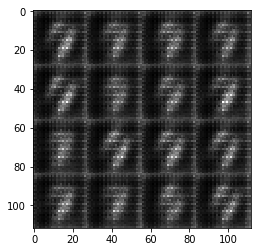

Epoch: 1/2(110)... Discriminator Loss: 1.292092... Generator Loss: 0.775896
Epoch: 1/2(120)... Discriminator Loss: 1.219436... Generator Loss: 0.605964
Epoch: 1/2(130)... Discriminator Loss: 1.353396... Generator Loss: 0.434951
Epoch: 1/2(140)... Discriminator Loss: 1.191339... Generator Loss: 0.685385
Epoch: 1/2(150)... Discriminator Loss: 1.045323... Generator Loss: 0.792079
Epoch: 1/2(160)... Discriminator Loss: 1.175952... Generator Loss: 0.995995
Epoch: 1/2(170)... Discriminator Loss: 1.328532... Generator Loss: 0.615452
Epoch: 1/2(180)... Discriminator Loss: 1.269221... Generator Loss: 0.621180
Epoch: 1/2(190)... Discriminator Loss: 1.230973... Generator Loss: 0.656992
Epoch: 1/2(200)... Discriminator Loss: 1.434843... Generator Loss: 0.565013


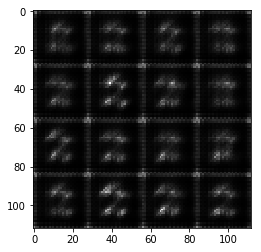

Epoch: 1/2(210)... Discriminator Loss: 1.275158... Generator Loss: 0.695172
Epoch: 1/2(220)... Discriminator Loss: 1.336100... Generator Loss: 0.621492
Epoch: 1/2(230)... Discriminator Loss: 1.307282... Generator Loss: 0.613412
Epoch: 1/2(240)... Discriminator Loss: 1.316804... Generator Loss: 0.518399
Epoch: 1/2(250)... Discriminator Loss: 1.325750... Generator Loss: 0.619851
Epoch: 1/2(260)... Discriminator Loss: 1.405716... Generator Loss: 0.607559
Epoch: 1/2(270)... Discriminator Loss: 1.259365... Generator Loss: 0.664180
Epoch: 1/2(280)... Discriminator Loss: 1.383949... Generator Loss: 0.567584
Epoch: 1/2(290)... Discriminator Loss: 1.256644... Generator Loss: 0.638539
Epoch: 1/2(300)... Discriminator Loss: 1.306537... Generator Loss: 0.571503


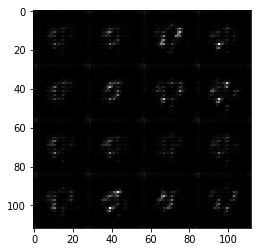

Epoch: 1/2(310)... Discriminator Loss: 1.263737... Generator Loss: 0.675719
Epoch: 1/2(320)... Discriminator Loss: 1.386685... Generator Loss: 0.628607
Epoch: 1/2(330)... Discriminator Loss: 1.274629... Generator Loss: 0.615634
Epoch: 1/2(340)... Discriminator Loss: 1.331378... Generator Loss: 0.549781
Epoch: 1/2(350)... Discriminator Loss: 1.320403... Generator Loss: 0.655371
Epoch: 1/2(360)... Discriminator Loss: 1.247921... Generator Loss: 0.611435
Epoch: 1/2(370)... Discriminator Loss: 1.268332... Generator Loss: 0.604164
Epoch: 1/2(380)... Discriminator Loss: 1.213159... Generator Loss: 0.744789
Epoch: 1/2(390)... Discriminator Loss: 1.236106... Generator Loss: 0.681154
Epoch: 1/2(400)... Discriminator Loss: 1.363004... Generator Loss: 0.592861


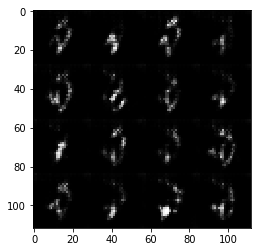

Epoch: 1/2(410)... Discriminator Loss: 1.320646... Generator Loss: 0.679633
Epoch: 1/2(420)... Discriminator Loss: 1.300697... Generator Loss: 0.595676
Epoch: 1/2(430)... Discriminator Loss: 1.312501... Generator Loss: 0.616343
Epoch: 1/2(440)... Discriminator Loss: 1.299413... Generator Loss: 0.803675
Epoch: 1/2(450)... Discriminator Loss: 1.276519... Generator Loss: 0.805607
Epoch: 1/2(460)... Discriminator Loss: 1.387259... Generator Loss: 0.666561
Epoch: 1/2(470)... Discriminator Loss: 1.310051... Generator Loss: 0.745748
Epoch: 1/2(480)... Discriminator Loss: 1.366002... Generator Loss: 0.704065
Epoch: 1/2(490)... Discriminator Loss: 1.351895... Generator Loss: 0.742960
Epoch: 1/2(500)... Discriminator Loss: 1.287398... Generator Loss: 0.633110


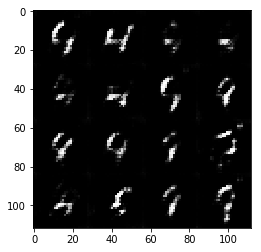

Epoch: 1/2(510)... Discriminator Loss: 1.329398... Generator Loss: 0.830792
Epoch: 1/2(520)... Discriminator Loss: 1.328672... Generator Loss: 0.584126
Epoch: 1/2(530)... Discriminator Loss: 1.345417... Generator Loss: 0.639786
Epoch: 1/2(540)... Discriminator Loss: 1.372474... Generator Loss: 0.671119
Epoch: 1/2(550)... Discriminator Loss: 1.334142... Generator Loss: 0.638528
Epoch: 1/2(560)... Discriminator Loss: 1.313730... Generator Loss: 0.658321
Epoch: 1/2(570)... Discriminator Loss: 1.318315... Generator Loss: 0.605749
Epoch: 1/2(580)... Discriminator Loss: 1.353980... Generator Loss: 0.651630
Epoch: 1/2(590)... Discriminator Loss: 1.373599... Generator Loss: 0.703214
Epoch: 1/2(600)... Discriminator Loss: 1.333617... Generator Loss: 0.629423


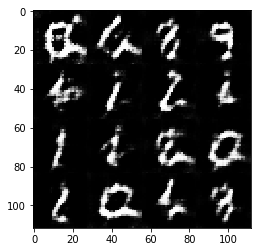

Epoch: 1/2(610)... Discriminator Loss: 1.370012... Generator Loss: 0.600981
Epoch: 1/2(620)... Discriminator Loss: 1.330293... Generator Loss: 0.739887
Epoch: 1/2(630)... Discriminator Loss: 1.326516... Generator Loss: 0.587309
Epoch: 1/2(640)... Discriminator Loss: 1.349466... Generator Loss: 0.621427
Epoch: 1/2(650)... Discriminator Loss: 1.314996... Generator Loss: 0.667749
Epoch: 1/2(660)... Discriminator Loss: 1.352976... Generator Loss: 0.598529
Epoch: 1/2(670)... Discriminator Loss: 1.321894... Generator Loss: 0.663109
Epoch: 1/2(680)... Discriminator Loss: 1.357821... Generator Loss: 0.681072
Epoch: 1/2(690)... Discriminator Loss: 1.335169... Generator Loss: 0.596807
Epoch: 1/2(700)... Discriminator Loss: 1.348367... Generator Loss: 0.598507


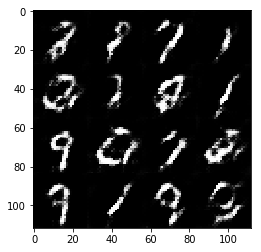

Epoch: 1/2(710)... Discriminator Loss: 1.360381... Generator Loss: 0.670968
Epoch: 1/2(720)... Discriminator Loss: 1.349827... Generator Loss: 0.677376
Epoch: 1/2(730)... Discriminator Loss: 1.342270... Generator Loss: 0.707967
Epoch: 1/2(740)... Discriminator Loss: 1.353830... Generator Loss: 0.647057
Epoch: 1/2(750)... Discriminator Loss: 1.357566... Generator Loss: 0.577082
Epoch: 1/2(760)... Discriminator Loss: 1.375615... Generator Loss: 0.653243
Epoch: 1/2(770)... Discriminator Loss: 1.385270... Generator Loss: 0.626030
Epoch: 1/2(780)... Discriminator Loss: 1.323702... Generator Loss: 0.660861
Epoch: 1/2(790)... Discriminator Loss: 1.398781... Generator Loss: 0.633559
Epoch: 1/2(800)... Discriminator Loss: 1.377993... Generator Loss: 0.591606


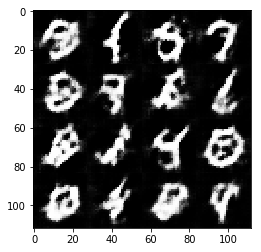

Epoch: 1/2(810)... Discriminator Loss: 1.379472... Generator Loss: 0.692899
Epoch: 1/2(820)... Discriminator Loss: 1.372730... Generator Loss: 0.621086
Epoch: 1/2(830)... Discriminator Loss: 1.410420... Generator Loss: 0.604631
Epoch: 1/2(840)... Discriminator Loss: 1.410067... Generator Loss: 0.634166
Epoch: 1/2(850)... Discriminator Loss: 1.351708... Generator Loss: 0.631689
Epoch: 1/2(860)... Discriminator Loss: 1.351226... Generator Loss: 0.632168
Epoch: 1/2(870)... Discriminator Loss: 1.350030... Generator Loss: 0.604944
Epoch: 1/2(880)... Discriminator Loss: 1.359861... Generator Loss: 0.637556
Epoch: 1/2(890)... Discriminator Loss: 1.380642... Generator Loss: 0.608491
Epoch: 1/2(900)... Discriminator Loss: 1.387748... Generator Loss: 0.635072


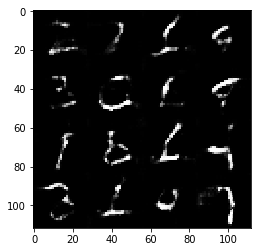

Epoch: 1/2(910)... Discriminator Loss: 1.357275... Generator Loss: 0.627459
Epoch: 1/2(920)... Discriminator Loss: 1.357947... Generator Loss: 0.619163
Epoch: 1/2(930)... Discriminator Loss: 1.410130... Generator Loss: 0.614300
Epoch: 2/2(10)... Discriminator Loss: 1.365856... Generator Loss: 0.627784
Epoch: 2/2(20)... Discriminator Loss: 1.370782... Generator Loss: 0.613373
Epoch: 2/2(30)... Discriminator Loss: 1.353373... Generator Loss: 0.620131
Epoch: 2/2(40)... Discriminator Loss: 1.378365... Generator Loss: 0.629304
Epoch: 2/2(50)... Discriminator Loss: 1.381223... Generator Loss: 0.633690
Epoch: 2/2(60)... Discriminator Loss: 1.388985... Generator Loss: 0.601137
Epoch: 2/2(70)... Discriminator Loss: 1.393258... Generator Loss: 0.645795
Epoch: 2/2(80)... Discriminator Loss: 1.384920... Generator Loss: 0.626013
Epoch: 2/2(90)... Discriminator Loss: 1.390384... Generator Loss: 0.666790
Epoch: 2/2(100)... Discriminator Loss: 1.341615... Generator Loss: 0.616351


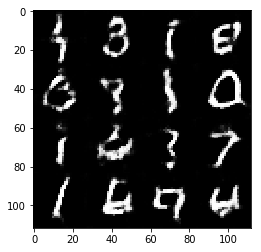

Epoch: 2/2(110)... Discriminator Loss: 1.349707... Generator Loss: 0.610241
Epoch: 2/2(120)... Discriminator Loss: 1.353665... Generator Loss: 0.594741
Epoch: 2/2(130)... Discriminator Loss: 1.372477... Generator Loss: 0.625209
Epoch: 2/2(140)... Discriminator Loss: 1.349886... Generator Loss: 0.629516
Epoch: 2/2(150)... Discriminator Loss: 1.370427... Generator Loss: 0.619956
Epoch: 2/2(160)... Discriminator Loss: 1.397933... Generator Loss: 0.622196
Epoch: 2/2(170)... Discriminator Loss: 1.393091... Generator Loss: 0.622481
Epoch: 2/2(180)... Discriminator Loss: 1.357794... Generator Loss: 0.592218
Epoch: 2/2(190)... Discriminator Loss: 1.347597... Generator Loss: 0.606470
Epoch: 2/2(200)... Discriminator Loss: 1.400682... Generator Loss: 0.659729


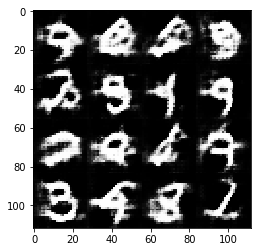

Epoch: 2/2(210)... Discriminator Loss: 1.331370... Generator Loss: 0.598040
Epoch: 2/2(220)... Discriminator Loss: 1.368936... Generator Loss: 0.631542
Epoch: 2/2(230)... Discriminator Loss: 1.355618... Generator Loss: 0.628545
Epoch: 2/2(240)... Discriminator Loss: 1.372839... Generator Loss: 0.623501
Epoch: 2/2(250)... Discriminator Loss: 1.394068... Generator Loss: 0.641441
Epoch: 2/2(260)... Discriminator Loss: 1.337080... Generator Loss: 0.619983
Epoch: 2/2(270)... Discriminator Loss: 1.394434... Generator Loss: 0.608495
Epoch: 2/2(280)... Discriminator Loss: 1.354023... Generator Loss: 0.611415
Epoch: 2/2(290)... Discriminator Loss: 1.396343... Generator Loss: 0.629283
Epoch: 2/2(300)... Discriminator Loss: 1.361907... Generator Loss: 0.592974


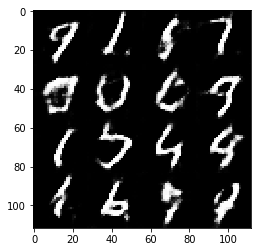

Epoch: 2/2(310)... Discriminator Loss: 1.354042... Generator Loss: 0.632415
Epoch: 2/2(320)... Discriminator Loss: 1.346437... Generator Loss: 0.638679
Epoch: 2/2(330)... Discriminator Loss: 1.372411... Generator Loss: 0.613837
Epoch: 2/2(340)... Discriminator Loss: 1.385631... Generator Loss: 0.644316
Epoch: 2/2(350)... Discriminator Loss: 1.346964... Generator Loss: 0.635018
Epoch: 2/2(360)... Discriminator Loss: 1.385552... Generator Loss: 0.613232
Epoch: 2/2(370)... Discriminator Loss: 1.377193... Generator Loss: 0.610774
Epoch: 2/2(380)... Discriminator Loss: 1.363924... Generator Loss: 0.614554
Epoch: 2/2(390)... Discriminator Loss: 1.369466... Generator Loss: 0.623498
Epoch: 2/2(400)... Discriminator Loss: 1.375140... Generator Loss: 0.640406


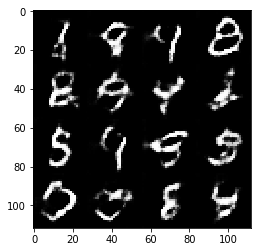

Epoch: 2/2(410)... Discriminator Loss: 1.358124... Generator Loss: 0.613786
Epoch: 2/2(420)... Discriminator Loss: 1.357163... Generator Loss: 0.594723
Epoch: 2/2(430)... Discriminator Loss: 1.375349... Generator Loss: 0.629490
Epoch: 2/2(440)... Discriminator Loss: 1.373016... Generator Loss: 0.619706
Epoch: 2/2(450)... Discriminator Loss: 1.376707... Generator Loss: 0.625532
Epoch: 2/2(460)... Discriminator Loss: 1.367595... Generator Loss: 0.630185
Epoch: 2/2(470)... Discriminator Loss: 1.375301... Generator Loss: 0.625079
Epoch: 2/2(480)... Discriminator Loss: 1.373467... Generator Loss: 0.622759
Epoch: 2/2(490)... Discriminator Loss: 1.374643... Generator Loss: 0.618549
Epoch: 2/2(500)... Discriminator Loss: 1.369690... Generator Loss: 0.614240


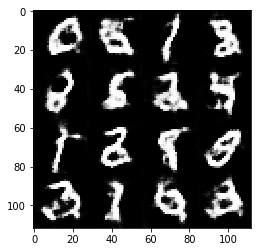

Epoch: 2/2(510)... Discriminator Loss: 1.399429... Generator Loss: 0.608350
Epoch: 2/2(520)... Discriminator Loss: 1.376127... Generator Loss: 0.612210
Epoch: 2/2(530)... Discriminator Loss: 1.356528... Generator Loss: 0.620714
Epoch: 2/2(540)... Discriminator Loss: 1.390141... Generator Loss: 0.661126
Epoch: 2/2(550)... Discriminator Loss: 1.385990... Generator Loss: 0.618698
Epoch: 2/2(560)... Discriminator Loss: 1.380020... Generator Loss: 0.611707
Epoch: 2/2(570)... Discriminator Loss: 1.381653... Generator Loss: 0.618713
Epoch: 2/2(580)... Discriminator Loss: 1.377797... Generator Loss: 0.611347
Epoch: 2/2(590)... Discriminator Loss: 1.355989... Generator Loss: 0.621555
Epoch: 2/2(600)... Discriminator Loss: 1.383748... Generator Loss: 0.623048


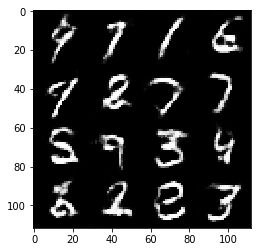

Epoch: 2/2(610)... Discriminator Loss: 1.365879... Generator Loss: 0.607799
Epoch: 2/2(620)... Discriminator Loss: 1.376795... Generator Loss: 0.636069
Epoch: 2/2(630)... Discriminator Loss: 1.352018... Generator Loss: 0.610086
Epoch: 2/2(640)... Discriminator Loss: 1.360902... Generator Loss: 0.596078
Epoch: 2/2(650)... Discriminator Loss: 1.369063... Generator Loss: 0.607076
Epoch: 2/2(660)... Discriminator Loss: 1.388834... Generator Loss: 0.623896
Epoch: 2/2(670)... Discriminator Loss: 1.364800... Generator Loss: 0.622561
Epoch: 2/2(680)... Discriminator Loss: 1.379684... Generator Loss: 0.603547
Epoch: 2/2(690)... Discriminator Loss: 1.360654... Generator Loss: 0.586706
Epoch: 2/2(700)... Discriminator Loss: 1.364448... Generator Loss: 0.658250


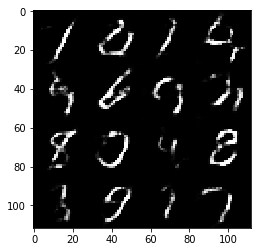

Epoch: 2/2(710)... Discriminator Loss: 1.388215... Generator Loss: 0.627706
Epoch: 2/2(720)... Discriminator Loss: 1.354195... Generator Loss: 0.584642
Epoch: 2/2(730)... Discriminator Loss: 1.359391... Generator Loss: 0.609828
Epoch: 2/2(740)... Discriminator Loss: 1.375940... Generator Loss: 0.609975
Epoch: 2/2(750)... Discriminator Loss: 1.426011... Generator Loss: 0.649025
Epoch: 2/2(760)... Discriminator Loss: 1.359019... Generator Loss: 0.587260
Epoch: 2/2(770)... Discriminator Loss: 1.389437... Generator Loss: 0.617568
Epoch: 2/2(780)... Discriminator Loss: 1.356017... Generator Loss: 0.598220
Epoch: 2/2(790)... Discriminator Loss: 1.358708... Generator Loss: 0.624282
Epoch: 2/2(800)... Discriminator Loss: 1.396817... Generator Loss: 0.647012


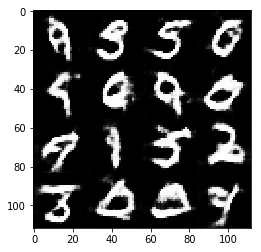

Epoch: 2/2(810)... Discriminator Loss: 1.353701... Generator Loss: 0.592582
Epoch: 2/2(820)... Discriminator Loss: 1.384496... Generator Loss: 0.631696
Epoch: 2/2(830)... Discriminator Loss: 1.373908... Generator Loss: 0.606152
Epoch: 2/2(840)... Discriminator Loss: 1.375811... Generator Loss: 0.622643
Epoch: 2/2(850)... Discriminator Loss: 1.367519... Generator Loss: 0.617900
Epoch: 2/2(860)... Discriminator Loss: 1.370023... Generator Loss: 0.619175
Epoch: 2/2(870)... Discriminator Loss: 1.361201... Generator Loss: 0.590748
Epoch: 2/2(880)... Discriminator Loss: 1.371384... Generator Loss: 0.642483
Epoch: 2/2(890)... Discriminator Loss: 1.389544... Generator Loss: 0.613672
Epoch: 2/2(900)... Discriminator Loss: 1.366153... Generator Loss: 0.595673


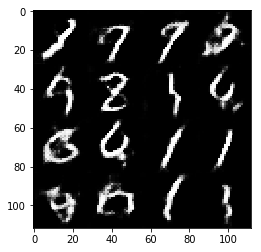

Epoch: 2/2(910)... Discriminator Loss: 1.382037... Generator Loss: 0.635589
Epoch: 2/2(920)... Discriminator Loss: 1.359972... Generator Loss: 0.601263
Epoch: 2/2(930)... Discriminator Loss: 1.387351... Generator Loss: 0.623055


In [166]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1(10)... Discriminator Loss: 1.344577... Generator Loss: 0.542282
Epoch: 1/1(20)... Discriminator Loss: 1.340080... Generator Loss: 0.654732
Epoch: 1/1(30)... Discriminator Loss: 1.309062... Generator Loss: 0.658137
Epoch: 1/1(40)... Discriminator Loss: 1.396492... Generator Loss: 0.701865
Epoch: 1/1(50)... Discriminator Loss: 1.407092... Generator Loss: 0.531031
Epoch: 1/1(60)... Discriminator Loss: 1.398088... Generator Loss: 0.588735
Epoch: 1/1(70)... Discriminator Loss: 1.345644... Generator Loss: 0.607057
Epoch: 1/1(80)... Discriminator Loss: 1.383445... Generator Loss: 0.708459
Epoch: 1/1(90)... Discriminator Loss: 1.390789... Generator Loss: 0.625131
Epoch: 1/1(100)... Discriminator Loss: 1.373616... Generator Loss: 0.630489


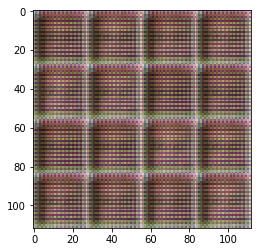

Epoch: 1/1(110)... Discriminator Loss: 1.389356... Generator Loss: 0.651815
Epoch: 1/1(120)... Discriminator Loss: 1.390034... Generator Loss: 0.657053
Epoch: 1/1(130)... Discriminator Loss: 1.413622... Generator Loss: 0.575891
Epoch: 1/1(140)... Discriminator Loss: 1.360341... Generator Loss: 0.664251
Epoch: 1/1(150)... Discriminator Loss: 1.363031... Generator Loss: 0.652632
Epoch: 1/1(160)... Discriminator Loss: 1.388280... Generator Loss: 0.652331
Epoch: 1/1(170)... Discriminator Loss: 1.408725... Generator Loss: 0.592865
Epoch: 1/1(180)... Discriminator Loss: 1.349116... Generator Loss: 0.669638
Epoch: 1/1(190)... Discriminator Loss: 1.360309... Generator Loss: 0.661507
Epoch: 1/1(200)... Discriminator Loss: 1.379130... Generator Loss: 0.562465


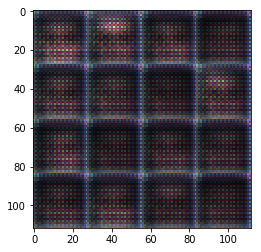

Epoch: 1/1(210)... Discriminator Loss: 1.356785... Generator Loss: 0.645707
Epoch: 1/1(220)... Discriminator Loss: 1.380889... Generator Loss: 0.661858
Epoch: 1/1(230)... Discriminator Loss: 1.384575... Generator Loss: 0.727808
Epoch: 1/1(240)... Discriminator Loss: 1.356134... Generator Loss: 0.645838
Epoch: 1/1(250)... Discriminator Loss: 1.363748... Generator Loss: 0.633186
Epoch: 1/1(260)... Discriminator Loss: 1.348819... Generator Loss: 0.580122
Epoch: 1/1(270)... Discriminator Loss: 1.367720... Generator Loss: 0.526767
Epoch: 1/1(280)... Discriminator Loss: 1.406844... Generator Loss: 0.638284
Epoch: 1/1(290)... Discriminator Loss: 1.421464... Generator Loss: 0.635248
Epoch: 1/1(300)... Discriminator Loss: 1.385340... Generator Loss: 0.626741


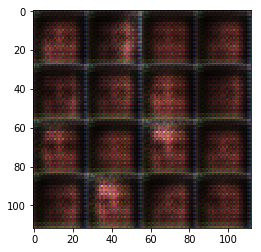

Epoch: 1/1(310)... Discriminator Loss: 1.342113... Generator Loss: 0.667196
Epoch: 1/1(320)... Discriminator Loss: 1.334411... Generator Loss: 0.621632
Epoch: 1/1(330)... Discriminator Loss: 1.345917... Generator Loss: 0.573529
Epoch: 1/1(340)... Discriminator Loss: 1.380855... Generator Loss: 0.559253
Epoch: 1/1(350)... Discriminator Loss: 1.350967... Generator Loss: 0.626012
Epoch: 1/1(360)... Discriminator Loss: 1.382219... Generator Loss: 0.662597
Epoch: 1/1(370)... Discriminator Loss: 1.363571... Generator Loss: 0.624460
Epoch: 1/1(380)... Discriminator Loss: 1.382132... Generator Loss: 0.661068
Epoch: 1/1(390)... Discriminator Loss: 1.329857... Generator Loss: 0.604729
Epoch: 1/1(400)... Discriminator Loss: 1.383045... Generator Loss: 0.579645


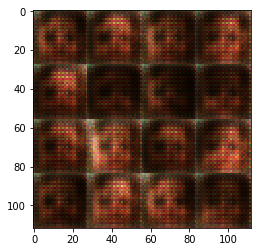

Epoch: 1/1(410)... Discriminator Loss: 1.346247... Generator Loss: 0.635990
Epoch: 1/1(420)... Discriminator Loss: 1.409287... Generator Loss: 0.667350
Epoch: 1/1(430)... Discriminator Loss: 1.317719... Generator Loss: 0.616938
Epoch: 1/1(440)... Discriminator Loss: 1.373735... Generator Loss: 0.653997
Epoch: 1/1(450)... Discriminator Loss: 1.390447... Generator Loss: 0.588589
Epoch: 1/1(460)... Discriminator Loss: 1.383321... Generator Loss: 0.588985
Epoch: 1/1(470)... Discriminator Loss: 1.368098... Generator Loss: 0.644176
Epoch: 1/1(480)... Discriminator Loss: 1.390971... Generator Loss: 0.629690
Epoch: 1/1(490)... Discriminator Loss: 1.366516... Generator Loss: 0.633099
Epoch: 1/1(500)... Discriminator Loss: 1.377115... Generator Loss: 0.641435


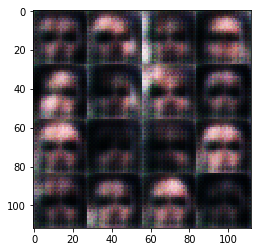

Epoch: 1/1(510)... Discriminator Loss: 1.391121... Generator Loss: 0.667071
Epoch: 1/1(520)... Discriminator Loss: 1.367547... Generator Loss: 0.619079
Epoch: 1/1(530)... Discriminator Loss: 1.409459... Generator Loss: 0.603969
Epoch: 1/1(540)... Discriminator Loss: 1.392249... Generator Loss: 0.597496
Epoch: 1/1(550)... Discriminator Loss: 1.372762... Generator Loss: 0.662379
Epoch: 1/1(560)... Discriminator Loss: 1.382914... Generator Loss: 0.602371
Epoch: 1/1(570)... Discriminator Loss: 1.397590... Generator Loss: 0.565300
Epoch: 1/1(580)... Discriminator Loss: 1.372901... Generator Loss: 0.652817
Epoch: 1/1(590)... Discriminator Loss: 1.380292... Generator Loss: 0.627488
Epoch: 1/1(600)... Discriminator Loss: 1.365997... Generator Loss: 0.585912


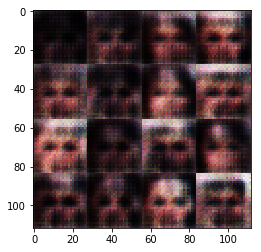

Epoch: 1/1(610)... Discriminator Loss: 1.366546... Generator Loss: 0.621858
Epoch: 1/1(620)... Discriminator Loss: 1.383545... Generator Loss: 0.639998
Epoch: 1/1(630)... Discriminator Loss: 1.382530... Generator Loss: 0.591290
Epoch: 1/1(640)... Discriminator Loss: 1.388623... Generator Loss: 0.614771
Epoch: 1/1(650)... Discriminator Loss: 1.360842... Generator Loss: 0.614718
Epoch: 1/1(660)... Discriminator Loss: 1.399246... Generator Loss: 0.588835
Epoch: 1/1(670)... Discriminator Loss: 1.358105... Generator Loss: 0.644130
Epoch: 1/1(680)... Discriminator Loss: 1.379736... Generator Loss: 0.613416
Epoch: 1/1(690)... Discriminator Loss: 1.387982... Generator Loss: 0.625655
Epoch: 1/1(700)... Discriminator Loss: 1.361134... Generator Loss: 0.604879


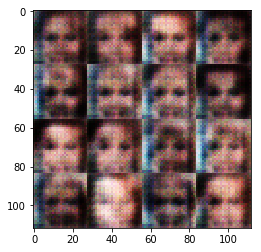

Epoch: 1/1(710)... Discriminator Loss: 1.377759... Generator Loss: 0.626278
Epoch: 1/1(720)... Discriminator Loss: 1.350767... Generator Loss: 0.605904
Epoch: 1/1(730)... Discriminator Loss: 1.362427... Generator Loss: 0.640592
Epoch: 1/1(740)... Discriminator Loss: 1.388077... Generator Loss: 0.648049
Epoch: 1/1(750)... Discriminator Loss: 1.358913... Generator Loss: 0.621166
Epoch: 1/1(760)... Discriminator Loss: 1.369525... Generator Loss: 0.631186
Epoch: 1/1(770)... Discriminator Loss: 1.379328... Generator Loss: 0.617168
Epoch: 1/1(780)... Discriminator Loss: 1.371980... Generator Loss: 0.646781
Epoch: 1/1(790)... Discriminator Loss: 1.378391... Generator Loss: 0.597891
Epoch: 1/1(800)... Discriminator Loss: 1.365782... Generator Loss: 0.601524


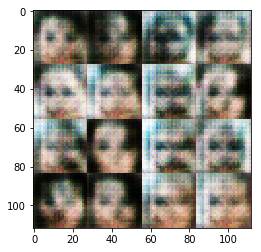

Epoch: 1/1(810)... Discriminator Loss: 1.376443... Generator Loss: 0.631048
Epoch: 1/1(820)... Discriminator Loss: 1.365265... Generator Loss: 0.601924
Epoch: 1/1(830)... Discriminator Loss: 1.370351... Generator Loss: 0.583159
Epoch: 1/1(840)... Discriminator Loss: 1.384128... Generator Loss: 0.615008
Epoch: 1/1(850)... Discriminator Loss: 1.374635... Generator Loss: 0.621486
Epoch: 1/1(860)... Discriminator Loss: 1.370403... Generator Loss: 0.614936
Epoch: 1/1(870)... Discriminator Loss: 1.354741... Generator Loss: 0.602227
Epoch: 1/1(880)... Discriminator Loss: 1.372027... Generator Loss: 0.621118
Epoch: 1/1(890)... Discriminator Loss: 1.366663... Generator Loss: 0.604755
Epoch: 1/1(900)... Discriminator Loss: 1.362847... Generator Loss: 0.608572


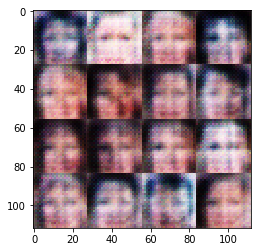

Epoch: 1/1(910)... Discriminator Loss: 1.359128... Generator Loss: 0.625078
Epoch: 1/1(920)... Discriminator Loss: 1.387220... Generator Loss: 0.632380
Epoch: 1/1(930)... Discriminator Loss: 1.369404... Generator Loss: 0.600015
Epoch: 1/1(940)... Discriminator Loss: 1.382492... Generator Loss: 0.619469
Epoch: 1/1(950)... Discriminator Loss: 1.387595... Generator Loss: 0.595419
Epoch: 1/1(960)... Discriminator Loss: 1.377179... Generator Loss: 0.622004
Epoch: 1/1(970)... Discriminator Loss: 1.374429... Generator Loss: 0.602201
Epoch: 1/1(980)... Discriminator Loss: 1.371553... Generator Loss: 0.621372
Epoch: 1/1(990)... Discriminator Loss: 1.356343... Generator Loss: 0.598518
Epoch: 1/1(1000)... Discriminator Loss: 1.378101... Generator Loss: 0.617931


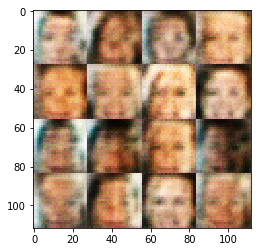

Epoch: 1/1(1010)... Discriminator Loss: 1.368029... Generator Loss: 0.607312
Epoch: 1/1(1020)... Discriminator Loss: 1.377452... Generator Loss: 0.614034
Epoch: 1/1(1030)... Discriminator Loss: 1.388663... Generator Loss: 0.602033
Epoch: 1/1(1040)... Discriminator Loss: 1.374924... Generator Loss: 0.593422
Epoch: 1/1(1050)... Discriminator Loss: 1.399097... Generator Loss: 0.576696
Epoch: 1/1(1060)... Discriminator Loss: 1.385627... Generator Loss: 0.583613
Epoch: 1/1(1070)... Discriminator Loss: 1.371814... Generator Loss: 0.623275
Epoch: 1/1(1080)... Discriminator Loss: 1.376292... Generator Loss: 0.605565
Epoch: 1/1(1090)... Discriminator Loss: 1.375562... Generator Loss: 0.608354
Epoch: 1/1(1100)... Discriminator Loss: 1.362828... Generator Loss: 0.599403


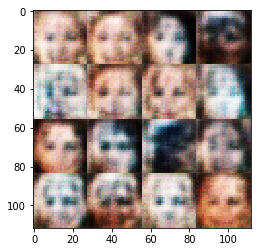

Epoch: 1/1(1110)... Discriminator Loss: 1.374032... Generator Loss: 0.605757
Epoch: 1/1(1120)... Discriminator Loss: 1.376715... Generator Loss: 0.609713
Epoch: 1/1(1130)... Discriminator Loss: 1.368486... Generator Loss: 0.591096
Epoch: 1/1(1140)... Discriminator Loss: 1.380667... Generator Loss: 0.600637
Epoch: 1/1(1150)... Discriminator Loss: 1.363498... Generator Loss: 0.639711
Epoch: 1/1(1160)... Discriminator Loss: 1.364970... Generator Loss: 0.604792
Epoch: 1/1(1170)... Discriminator Loss: 1.389178... Generator Loss: 0.665511
Epoch: 1/1(1180)... Discriminator Loss: 1.383753... Generator Loss: 0.600230
Epoch: 1/1(1190)... Discriminator Loss: 1.379731... Generator Loss: 0.605986
Epoch: 1/1(1200)... Discriminator Loss: 1.370506... Generator Loss: 0.619570


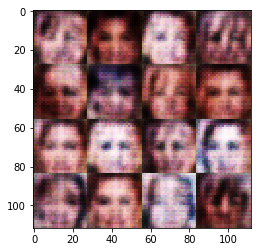

Epoch: 1/1(1210)... Discriminator Loss: 1.365712... Generator Loss: 0.629264
Epoch: 1/1(1220)... Discriminator Loss: 1.378408... Generator Loss: 0.581022
Epoch: 1/1(1230)... Discriminator Loss: 1.377422... Generator Loss: 0.633510
Epoch: 1/1(1240)... Discriminator Loss: 1.391349... Generator Loss: 0.613718
Epoch: 1/1(1250)... Discriminator Loss: 1.373789... Generator Loss: 0.623251
Epoch: 1/1(1260)... Discriminator Loss: 1.377443... Generator Loss: 0.628371
Epoch: 1/1(1270)... Discriminator Loss: 1.367725... Generator Loss: 0.565639
Epoch: 1/1(1280)... Discriminator Loss: 1.378340... Generator Loss: 0.597672
Epoch: 1/1(1290)... Discriminator Loss: 1.374324... Generator Loss: 0.622173
Epoch: 1/1(1300)... Discriminator Loss: 1.372924... Generator Loss: 0.603833


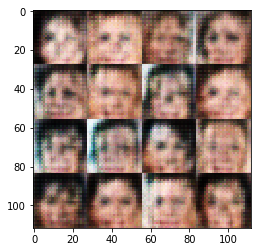

Epoch: 1/1(1310)... Discriminator Loss: 1.363997... Generator Loss: 0.589060
Epoch: 1/1(1320)... Discriminator Loss: 1.366825... Generator Loss: 0.614525
Epoch: 1/1(1330)... Discriminator Loss: 1.370426... Generator Loss: 0.636738
Epoch: 1/1(1340)... Discriminator Loss: 1.361747... Generator Loss: 0.603269
Epoch: 1/1(1350)... Discriminator Loss: 1.364516... Generator Loss: 0.596842
Epoch: 1/1(1360)... Discriminator Loss: 1.367678... Generator Loss: 0.532872
Epoch: 1/1(1370)... Discriminator Loss: 1.372137... Generator Loss: 0.642636
Epoch: 1/1(1380)... Discriminator Loss: 1.366414... Generator Loss: 0.581074
Epoch: 1/1(1390)... Discriminator Loss: 1.373467... Generator Loss: 0.626979
Epoch: 1/1(1400)... Discriminator Loss: 1.364355... Generator Loss: 0.596107


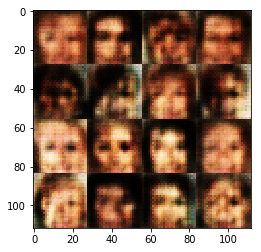

Epoch: 1/1(1410)... Discriminator Loss: 1.381261... Generator Loss: 0.617276
Epoch: 1/1(1420)... Discriminator Loss: 1.434457... Generator Loss: 0.514060
Epoch: 1/1(1430)... Discriminator Loss: 1.390464... Generator Loss: 0.611673
Epoch: 1/1(1440)... Discriminator Loss: 1.375963... Generator Loss: 0.651717
Epoch: 1/1(1450)... Discriminator Loss: 1.383205... Generator Loss: 0.605291
Epoch: 1/1(1460)... Discriminator Loss: 1.381513... Generator Loss: 0.608289
Epoch: 1/1(1470)... Discriminator Loss: 1.392849... Generator Loss: 0.717045
Epoch: 1/1(1480)... Discriminator Loss: 1.364642... Generator Loss: 0.675719
Epoch: 1/1(1490)... Discriminator Loss: 1.374935... Generator Loss: 0.607757
Epoch: 1/1(1500)... Discriminator Loss: 1.373005... Generator Loss: 0.634209


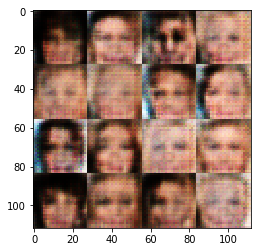

Epoch: 1/1(1510)... Discriminator Loss: 1.381747... Generator Loss: 0.629003
Epoch: 1/1(1520)... Discriminator Loss: 1.372470... Generator Loss: 0.622676
Epoch: 1/1(1530)... Discriminator Loss: 1.376713... Generator Loss: 0.607104
Epoch: 1/1(1540)... Discriminator Loss: 1.374869... Generator Loss: 0.630393
Epoch: 1/1(1550)... Discriminator Loss: 1.367984... Generator Loss: 0.581227
Epoch: 1/1(1560)... Discriminator Loss: 1.392931... Generator Loss: 0.575052
Epoch: 1/1(1570)... Discriminator Loss: 1.364926... Generator Loss: 0.604654
Epoch: 1/1(1580)... Discriminator Loss: 1.372172... Generator Loss: 0.605662
Epoch: 1/1(1590)... Discriminator Loss: 1.360072... Generator Loss: 0.615532
Epoch: 1/1(1600)... Discriminator Loss: 1.267831... Generator Loss: 0.597644


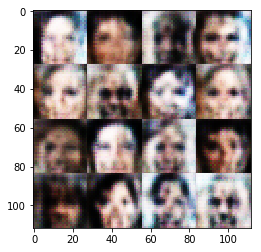

Epoch: 1/1(1610)... Discriminator Loss: 1.269812... Generator Loss: 0.611618
Epoch: 1/1(1620)... Discriminator Loss: 1.397748... Generator Loss: 0.695744
Epoch: 1/1(1630)... Discriminator Loss: 1.375528... Generator Loss: 0.678565
Epoch: 1/1(1640)... Discriminator Loss: 1.389395... Generator Loss: 0.623814
Epoch: 1/1(1650)... Discriminator Loss: 1.352729... Generator Loss: 0.643302
Epoch: 1/1(1660)... Discriminator Loss: 1.389111... Generator Loss: 0.578532
Epoch: 1/1(1670)... Discriminator Loss: 1.372570... Generator Loss: 0.646959
Epoch: 1/1(1680)... Discriminator Loss: 1.354125... Generator Loss: 0.664405
Epoch: 1/1(1690)... Discriminator Loss: 1.396882... Generator Loss: 0.733537
Epoch: 1/1(1700)... Discriminator Loss: 1.383648... Generator Loss: 0.668477


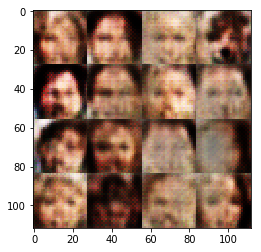

Epoch: 1/1(1710)... Discriminator Loss: 1.362785... Generator Loss: 0.611874
Epoch: 1/1(1720)... Discriminator Loss: 1.393347... Generator Loss: 0.663160
Epoch: 1/1(1730)... Discriminator Loss: 1.378936... Generator Loss: 0.643838
Epoch: 1/1(1740)... Discriminator Loss: 1.378791... Generator Loss: 0.634436
Epoch: 1/1(1750)... Discriminator Loss: 1.369534... Generator Loss: 0.597737
Epoch: 1/1(1760)... Discriminator Loss: 1.321919... Generator Loss: 0.635853
Epoch: 1/1(1770)... Discriminator Loss: 1.389475... Generator Loss: 0.723026
Epoch: 1/1(1780)... Discriminator Loss: 1.379268... Generator Loss: 0.692478
Epoch: 1/1(1790)... Discriminator Loss: 1.381065... Generator Loss: 0.619574
Epoch: 1/1(1800)... Discriminator Loss: 1.376868... Generator Loss: 0.639626


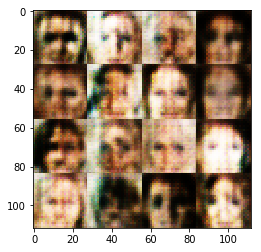

Epoch: 1/1(1810)... Discriminator Loss: 1.375152... Generator Loss: 0.649053
Epoch: 1/1(1820)... Discriminator Loss: 1.375157... Generator Loss: 0.638982
Epoch: 1/1(1830)... Discriminator Loss: 1.384921... Generator Loss: 0.619599
Epoch: 1/1(1840)... Discriminator Loss: 1.367160... Generator Loss: 0.621169
Epoch: 1/1(1850)... Discriminator Loss: 1.383580... Generator Loss: 0.605126
Epoch: 1/1(1860)... Discriminator Loss: 1.375980... Generator Loss: 0.613223
Epoch: 1/1(1870)... Discriminator Loss: 1.288179... Generator Loss: 0.549373
Epoch: 1/1(1880)... Discriminator Loss: 1.389210... Generator Loss: 0.627869
Epoch: 1/1(1890)... Discriminator Loss: 1.377214... Generator Loss: 0.645505
Epoch: 1/1(1900)... Discriminator Loss: 1.379282... Generator Loss: 0.625234


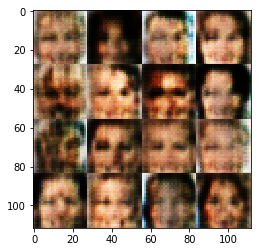

Epoch: 1/1(1910)... Discriminator Loss: 1.377381... Generator Loss: 0.624476
Epoch: 1/1(1920)... Discriminator Loss: 1.378364... Generator Loss: 0.606710
Epoch: 1/1(1930)... Discriminator Loss: 1.345909... Generator Loss: 0.610573
Epoch: 1/1(1940)... Discriminator Loss: 1.324151... Generator Loss: 0.622024
Epoch: 1/1(1950)... Discriminator Loss: 1.225297... Generator Loss: 0.615040
Epoch: 1/1(1960)... Discriminator Loss: 1.330899... Generator Loss: 0.684900
Epoch: 1/1(1970)... Discriminator Loss: 1.388878... Generator Loss: 0.665761
Epoch: 1/1(1980)... Discriminator Loss: 1.304497... Generator Loss: 0.630318
Epoch: 1/1(1990)... Discriminator Loss: 1.339344... Generator Loss: 0.606242
Epoch: 1/1(2000)... Discriminator Loss: 1.355188... Generator Loss: 0.611313


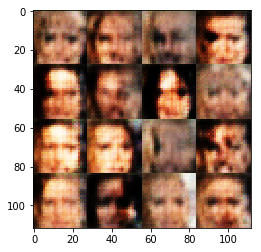

Epoch: 1/1(2010)... Discriminator Loss: 1.337186... Generator Loss: 0.595139
Epoch: 1/1(2020)... Discriminator Loss: 1.411654... Generator Loss: 0.674288
Epoch: 1/1(2030)... Discriminator Loss: 1.326918... Generator Loss: 0.591757
Epoch: 1/1(2040)... Discriminator Loss: 1.377432... Generator Loss: 0.671417
Epoch: 1/1(2050)... Discriminator Loss: 1.364788... Generator Loss: 0.642467
Epoch: 1/1(2060)... Discriminator Loss: 1.392902... Generator Loss: 0.605158
Epoch: 1/1(2070)... Discriminator Loss: 1.389398... Generator Loss: 0.689905
Epoch: 1/1(2080)... Discriminator Loss: 1.372189... Generator Loss: 0.626231
Epoch: 1/1(2090)... Discriminator Loss: 1.325104... Generator Loss: 0.609674
Epoch: 1/1(2100)... Discriminator Loss: 1.342890... Generator Loss: 0.615033


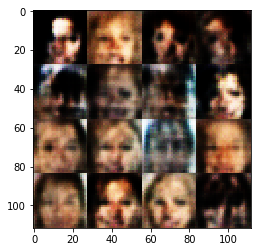

Epoch: 1/1(2110)... Discriminator Loss: 1.405629... Generator Loss: 0.662543
Epoch: 1/1(2120)... Discriminator Loss: 1.376500... Generator Loss: 0.643845
Epoch: 1/1(2130)... Discriminator Loss: 1.415173... Generator Loss: 0.509526
Epoch: 1/1(2140)... Discriminator Loss: 1.351850... Generator Loss: 0.623966
Epoch: 1/1(2150)... Discriminator Loss: 1.384192... Generator Loss: 0.426752
Epoch: 1/1(2160)... Discriminator Loss: 1.342195... Generator Loss: 0.646563
Epoch: 1/1(2170)... Discriminator Loss: 1.372657... Generator Loss: 0.602369
Epoch: 1/1(2180)... Discriminator Loss: 1.449972... Generator Loss: 0.408628
Epoch: 1/1(2190)... Discriminator Loss: 1.391556... Generator Loss: 0.629383
Epoch: 1/1(2200)... Discriminator Loss: 1.375054... Generator Loss: 0.654915


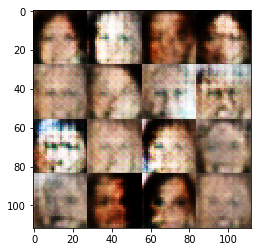

Epoch: 1/1(2210)... Discriminator Loss: 1.370855... Generator Loss: 0.621496
Epoch: 1/1(2220)... Discriminator Loss: 1.373505... Generator Loss: 0.652109
Epoch: 1/1(2230)... Discriminator Loss: 1.363889... Generator Loss: 0.595774
Epoch: 1/1(2240)... Discriminator Loss: 1.375228... Generator Loss: 0.679034
Epoch: 1/1(2250)... Discriminator Loss: 1.277339... Generator Loss: 0.619691
Epoch: 1/1(2260)... Discriminator Loss: 1.392773... Generator Loss: 0.649119
Epoch: 1/1(2270)... Discriminator Loss: 1.374605... Generator Loss: 0.620720
Epoch: 1/1(2280)... Discriminator Loss: 1.340773... Generator Loss: 0.575583
Epoch: 1/1(2290)... Discriminator Loss: 1.414187... Generator Loss: 0.690663
Epoch: 1/1(2300)... Discriminator Loss: 1.377708... Generator Loss: 0.649759


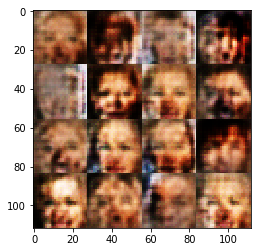

Epoch: 1/1(2310)... Discriminator Loss: 1.386505... Generator Loss: 0.629247
Epoch: 1/1(2320)... Discriminator Loss: 1.372697... Generator Loss: 0.606070
Epoch: 1/1(2330)... Discriminator Loss: 1.384340... Generator Loss: 0.616466
Epoch: 1/1(2340)... Discriminator Loss: 1.342473... Generator Loss: 0.554741
Epoch: 1/1(2350)... Discriminator Loss: 1.357216... Generator Loss: 0.652298
Epoch: 1/1(2360)... Discriminator Loss: 1.382493... Generator Loss: 0.664687
Epoch: 1/1(2370)... Discriminator Loss: 1.378579... Generator Loss: 0.655826
Epoch: 1/1(2380)... Discriminator Loss: 1.355525... Generator Loss: 0.520007
Epoch: 1/1(2390)... Discriminator Loss: 1.391814... Generator Loss: 0.672743
Epoch: 1/1(2400)... Discriminator Loss: 1.374317... Generator Loss: 0.649993


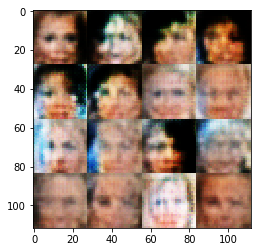

Epoch: 1/1(2410)... Discriminator Loss: 1.377128... Generator Loss: 0.605902
Epoch: 1/1(2420)... Discriminator Loss: 1.371423... Generator Loss: 0.523822
Epoch: 1/1(2430)... Discriminator Loss: 1.350742... Generator Loss: 0.638851
Epoch: 1/1(2440)... Discriminator Loss: 1.378367... Generator Loss: 0.646626
Epoch: 1/1(2450)... Discriminator Loss: 1.391065... Generator Loss: 0.695452
Epoch: 1/1(2460)... Discriminator Loss: 1.381465... Generator Loss: 0.640053
Epoch: 1/1(2470)... Discriminator Loss: 1.352078... Generator Loss: 0.618879
Epoch: 1/1(2480)... Discriminator Loss: 1.360768... Generator Loss: 0.641856
Epoch: 1/1(2490)... Discriminator Loss: 1.366733... Generator Loss: 0.523878
Epoch: 1/1(2500)... Discriminator Loss: 1.359091... Generator Loss: 0.597261


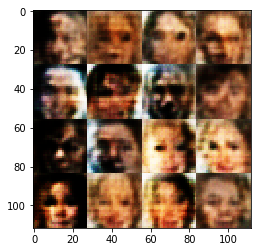

Epoch: 1/1(2510)... Discriminator Loss: 1.419138... Generator Loss: 0.491503


KeyboardInterrupt: 

In [165]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.